# Домашняя работа 3. Бустинг

Максимальная оценка 10 баллов

In [1]:
!pip install numpy==1.23.5
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston # sorry
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

  Using cached numpy-1.23.5-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.5 which is incompatible.


/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Задание 1. Градиентный бустинг своими руками  (4 балла)

Вам нужно реализовать упрощенный вариант градиентного бутсинга для задачи регресси. 


**Напоминание, как это работает:**

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается так:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu \in [0, 1]$ — темп обучения (гиперпараметр), $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма в ходе решения оптимизационной задачи:

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$


Заметьте, что в формуле выше нет $\nu$. Этот гиперпараметр используется для сокращения длины шага, оптимального при составлении композиции $a_N$. Идея отклонения от оптимума должна быть вам уже знакома как способ борьбы с переобучением, когда мы специально форсим модель работать чуть хуже, чем могла бы, на текущем шаге, чтобы сохранить обобщающую способность и не подогнаться под тренировочную выборку (или под шум).

С потерей в 0.5 балла можете принять $\gamma_N = 1$ для каждого $N$. На полный балл необходимо реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь $L$ возьмите MSE.

В качестве базовой модели можете использовать `DecisionTreeRegressor` из `sklearn`.
Для решения оптимизационной задачки можно воспользоваться алгоритмами из любых библиотек, например, `scipy.optimize`, или найти оптимум перебором по сетке из некоторого разумного диапазона.

Можно дописывать свои функции, если необходимо.

In [3]:
class GradientBoosting:
    def __init__(
        self, 
        base_model_class: object = DecisionTreeRegressor,
        base_model_params: dict = {'max_depth': None}, 
        n_estimators: int = 10,
        learning_rate: float = 0.1
    ):
        """
        
        Args:
          base_model_class: Class of the base learner.

          base_model_params: Hyperparameters of the base learner.
          
          n_estimators: Number of boosting stages.
          
          learning_rate: Value used to shrink contribution of each base learner to the model. 
          
        """
        
        self.base_model_class = base_model_class
        self.base_model_params = base_model_params
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        
        # list for optimal gammas at each iteration
        self.gammas = []
        
        # list for base models
        self.models = []
        
        
    def find_optimal_gamma(self, 
                           y: np.array, 
                           old_predictions: np.array,
                           new_predictions: np.array) -> float:
        """You may add arguments if it's necessary for your optimization algorithm.
        
        Args:
          y: Target variable.

          old_predictions: Prediction of the additive model at the previous stage.
          
          new_predictions: Prediction of the base learner at the current stage. 
          
        Returns:
          Optimal value for gamma.
          
        """
        gamma = np.sum((old_predictions - y) * new_predictions) / (len(y) * np.sum(old_predictions ** 2)) #Считаем гамму по оптимизационной формуле
        #Оптимизационная формула взята отсюда и верна для выбранного мной mse: https://towardsdatascience.com/gradient-boosting-in-python-from-scratch-788d1cf1ca7
        self.gammas.append(gamma)
        return gamma
              
        
    def _fit_base_model(self, X: np.ndarray, y: np.array):
        """Train one base learner. 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted base learner.
          
        """    
        mod = self.base_model_class(**self.base_model_params) #Задаем параметры и обучаем базовую модель
        return mod.fit(X, y)
    
        
    def fit(self, X: np.ndarray, y: np.array):
        """Train boosting ("sum" of base learners). 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted boosting.
          
        """
        a_0 = np.sum(y) / len(y) #Обучаем первоначальную базовую модель - по оптимизационной формуле MSE выходит, что это будет просто среднее арифметическое
        self.models.append(a_0)
        
        a_new = a_0
         
        for i in range(self.n_estimators):
            a_pred = a_new
            
            s = y - a_pred #Считаем остатки по оптимизационной формуле - изначально я выбрал вариацию mse со знаменателем, равным 2, а не N. Эта вариация общеиспользуемая и ползволяет брать красивую, простую производную для подсчета остатков
            
            b_new = self._fit_base_model(X, s) #Обучаем новую базовую модель на остатках
            self.models.append(b_new) #Добавляем обученную на остатках base model
            
            a_new = a_pred + self.learning_rate * self.find_optimal_gamma(y, a_pred, b_new.predict(X)) * b_new.predict(X) #Обновляем модель
            

    def predict(self, X: np.ndarray):
        """Make prediction of fitted boosting. 
        
        Args:
          X: Feature matrix


        Returns:
          Prediction of fitted boosting.
          
        """
        y_hat = self.models[0] #Добавляем начальный прогноз
        
        for i in range(1, len(self.models)):
            y_hat += self.models[i].predict(X) / self.n_estimators #Добавляем предсказания базовых моделей по формуле с лекции
 
        return y_hat 

Проверьте вашу реализацию на бостонском датасете. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor (не меняйте параметры сида).

In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
from sklearn.ensemble import GradientBoostingRegressor #Будем использовать его в качестве базовой модели, иначе переиграть не выйдет

In [7]:
#Здесь модель с уже подобранными методом 'тыка' гиперпараметрами
#Чтобы дождать нужного скора, мне пришлось очень долго ждать (я делал несколько итерация по 100 штук)
#Поэтому приложу скриншот получившегося однажды значения, найти его можно в следующей ячейке
#Это похоже на выброс, потому что обычно значения тут лежат в диапазоне 9.8-10.1  
#Но все равно стоковая модель в итоге переиграна
for i in range(100):
    gb = GradientBoosting()
    gb.__init__(base_model_class = GradientBoostingRegressor, n_estimators = 17, base_model_params = {'max_depth':6}, learning_rate=0.2)
    gb.fit(X=X_train, y=y_train)
    print(mean_squared_error(y_test, gb.predict(X_test)))

9.909492682014271
9.960217985584677


KeyboardInterrupt: 

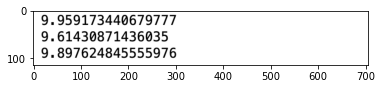

In [8]:
import requests #код с консультации по выводу картинок в юпитер ноутбук
from PIL import Image
from io import BytesIO
%matplotlib inline
url = "https://i.postimg.cc/wjWsWQ8R/2022-12-02-10-09-23.png"
response = requests.get(url)
img_before = np.asarray(Image.open(BytesIO(response.content)))
plt.imshow(img_before)

### Задание 2. Сравнение подходов (3 балла)

Скачайте данные о выдаче кредитов. Это данные с kaggle, целевая переменная `y` показывает, вернуло ли кредит физическое лицо.

In [9]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [10]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
845,36,technician,single,professional.course,no,no,no,cellular,jul,thu,...,4,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,-1
654,46,admin.,divorced,basic.9y,unknown,no,no,telephone,may,wed,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,-1
1942,39,services,divorced,high.school,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,-1
5478,35,self-employed,married,university.degree,no,yes,no,cellular,aug,thu,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,1
1582,52,admin.,single,university.degree,no,yes,no,cellular,jun,mon,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,1


In [11]:
#Сначала закодируем категориальные признаки
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

y = enc.fit_transform(df[['y']])

X = df.drop(columns = ['duration', 'y'],axis = 1)

for i in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']:
    X[i] = enc.fit_transform(df[[i]])


    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

In [12]:
X.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
3991,56,9.0,1.0,5.0,0.0,2.0,0.0,1.0,6.0,1.0,5,999,0,1.0,-1.8,93.876,-40.0,0.682,5008.7
4907,28,0.0,1.0,3.0,0.0,2.0,0.0,1.0,6.0,4.0,2,999,0,1.0,1.1,93.994,-36.4,4.856,5191.0
4313,46,0.0,1.0,6.0,0.0,2.0,0.0,1.0,0.0,4.0,7,999,0,1.0,-1.8,93.075,-47.1,1.405,5099.1
9021,43,1.0,1.0,0.0,0.0,2.0,2.0,0.0,6.0,3.0,2,999,0,1.0,-1.8,92.893,-46.2,1.291,5099.1
510,30,0.0,0.0,3.0,0.0,2.0,0.0,1.0,6.0,2.0,1,999,0,1.0,1.1,93.994,-36.4,4.855,5191.0


In [13]:
Models = ['Случайный лес', 'Бэггинг на деревьях', 'Бэггинг с базовой моделью бустинга', 'Бэггинг на логистических регрессиях']
Scores = [] #Используем это далее для сравнения

In [14]:
from sklearn.ensemble import RandomForestClassifier #Обучаем модель

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/var/folders/9d/gc4t49ts0js05tjpd78zspl40000gp/T/ipykernel_20346/8811780.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier()

In [15]:
Scores.append(rf.score(X_test, y_test))
print('Score модели:', rf.score(X_test, y_test)) #Пользуемся стоковым скором

Score модели: 0.7323275862068965


In [16]:
#Дополнительная, интересная информация
print("Угадали такую долю тех, кому выдан кредит", np.sum(rf.predict(X_test) + y_test.T[0] == 2) / np.sum(y_test.T[0] == 1))

Угадали такую долю тех, кому выдан кредит 0.64715860899067


In [17]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1))
clf.fit(X_train, y_train)

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=DecisionTreeClassifier())

In [18]:
Scores.append(clf.score(X_test, y_test))
print('Score модели:', clf.score(X_test, y_test))

Score модели: 0.6961206896551724


In [19]:
#Дополнительная, интересная информация
print("Угадали такую долю тех, кому выдан кредит", np.sum(clf.predict(X_test) + y_test.T[0] == 2) / np.sum(y_test.T[0] == 1))

Угадали такую долю тех, кому выдан кредит 0.6140797285835454


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

clf = BaggingClassifier(base_estimator=GradientBoostingClassifier(n_estimators=200))
clf.fit(X_train, y_train)

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=GradientBoostingClassifier(n_estimators=200))

In [21]:
Scores.append(clf.score(X_test, y_test))
print('Score модели', clf.score(X_test, y_test))

Score модели 0.7538793103448276


In [22]:
#Дополнительная, интересная информация
print("Угадали такую долю тех, кому выдан кредит", np.sum(clf.predict(X_test) + y_test.T[0] == 2) / np.sum(y_test.T[0] == 1))

Угадали такую долю тех, кому выдан кредит 0.6522476675148431


In [23]:
from sklearn.linear_model import LogisticRegression

clf = BaggingClassifier(base_estimator=LogisticRegression())
clf.fit(X_train, y_train)

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

BaggingClassifier(base_estimator=LogisticRegression())

In [24]:
Scores.append(clf.score(X_test, y_test))
print('Score модели', clf.score(X_test, y_test))

Score модели 0.7142241379310345


In [25]:
#Дополнительная, интересная информация
print("Угадали такую долю тех, кому выдан кредит", np.sum(clf.predict(X_test) + y_test.T[0] == 2) / np.sum(y_test.T[0] == 1))

Угадали такую долю тех, кому выдан кредит 0.6946564885496184


Решите задачу предсказания возвращения кредита методами, перечисленными ниже:

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

Используйте логистическую регрессию, случайный лес, `GradientBoostingClassifier` и `BaggingClassifier` из `sklearn`.

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается?


In [26]:
print('1) Значение ошибки')
for i in range(4):
    print(Models[i], Scores[i])

1) Значение ошибки
Случайный лес 0.7323275862068965
Бэггинг на деревьях 0.6961206896551724
Бэггинг с базовой моделью бустинга 0.7538793103448276
Бэггинг на логистических регрессиях 0.7142241379310345


Наилучшее качество имеет модель Бэггинга с базовой моделью бустинга. Это связано с тем, что метод совмещает в себе две самых сильных моделей: на это в том числе намекает тот факт, что именно этот алгоритм работает заметно дольше других

2) Переобучение

Я решил сравнить значения лоссов (mse) при разных значениях размера обучающей выборке. Дальнейшие циклы просто составляют массив со значениями всех лоссов. Далее они будут сравнены на графике - тот, у которого лосс со временем будет сильнее всего расти и будет сильнее всего переобучаться

Выполнение всех алгоритмов может занимать 15-20 минут, поэтому, если не хочется ждать, приложу скриншот итогового графика, его можно найти далее

In [28]:
mse_1 = [] #Создаем список со всеми mse
for i in np.arange(0.05, 1, 0.01): #Пробегаемся по разным значениям размера trainа, обучаем модель и считаем ошибку

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    mse_1.append(mean_squared_error(y_test, rf.predict(X_test)))

/var/folders/9d/gc4t49ts0js05tjpd78zspl40000gp/T/ipykernel_20346/2283787129.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/var/folders/9d/gc4t49ts0js05tjpd78zspl40000gp/T/ipykernel_20346/2283787129.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/var/folders/9d/gc4t49ts0js05tjpd78zspl40000gp/T/ipykernel_20346/2283787129.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/var/folders/9d/gc4t49ts0js05tjpd78zspl40000gp/T/ipykernel_20346/2283787129.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,)

KeyboardInterrupt: 

In [31]:
mse_2 = []
for i in np.arange(0.05, 1, 0.01):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
    
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1))
    clf.fit(X_train, y_train)

    mse_2.append(mean_squared_error(y_test, clf.predict(X_test)))

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

KeyboardInterrupt: 

In [32]:
mse_3 = []
for i in np.arange(0.05, 1, 0.01):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
    
    clf = BaggingClassifier(base_estimator=GradientBoostingClassifier(n_estimators=200))
    clf.fit(X_train, y_train)

    mse_3.append(mean_squared_error(y_test, clf.predict(X_test)))

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [33]:
mse_4 = []
for i in np.arange(0.05, 1, 0.01):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i)
    
    clf = BaggingClassifier(base_estimator=LogisticRegression())
    clf.fit(X_train, y_train)

    mse_4.append(mean_squared_error(y_test, clf.predict(X_test)))

/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (95,) and (3,)

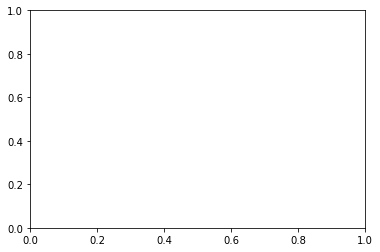

In [34]:
x = np.arange(0.05, 1, 0.01)[::-1] #Здесь строим графики
plt.plot(x, mse_1, label = 'Случайный лес')
plt.plot(x, mse_2, label = 'Бэггинг на деревьях')
plt.plot(x, mse_3, label = 'Бэггинг с базовой моделью бустинга')
plt.plot(x, mse_4, label = 'Бэггинг на логистических регрессиях')
plt.title('Значения лосса (mse) в зависимости от размера обучающей выборки')
plt.legend()
plt.show()

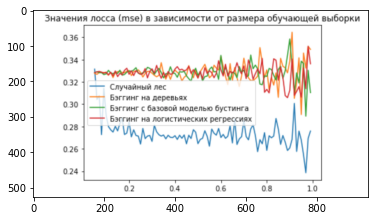

In [35]:
#Выведем картинку
url = "https://i.postimg.cc/qRmYCwbp/2022-12-01-22-09-25.png"
response = requests.get(url)
img_before = np.asarray(Image.open(BytesIO(response.content)))
plt.imshow(img_before)

Вывод: Видно, что сильнее всего переобучаются бустинги, а слабее - случайный лес

### Задание 3. Современные бустинги (3 балла)

Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost). Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев). Получилось ли круче, чем с моделями выше?

Я выбрал xgboost для сравнения

In [36]:
pip install xgboost

  Using cached numpy-1.22.4-cp39-cp39-macosx_10_15_x86_64.whl (17.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [37]:
import xgboost as xgb
from xgboost import XGBClassifier

In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#Будем искать оптимальные параметры с помощью гридсерча
#Учитывая, что я делаю 1440 фитов - это очень медленный алгоритм (больше 15 минут), но и очень правильный
#Если его запустить, то он выдаст такую же (или очень похожую модель, так как я не задавал seed), показанную далее
#Для удобства я просто вставил найденную модель далее
params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.6, 0.8], 'max_depth': [4, 5, 6, 7, 8, 9], 'n_estimators': [40, 100, 150, 200]}

xg_cl = XGBClassifier()

grid_search = GridSearchCV(
    estimator=xg_cl,
    param_grid=params,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X, y)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py", line 2037, in try_parse
Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py", line 2037, in try_parse
Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda3/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda3/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda3/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda3/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda3/lib/python3.9/runpy.py", line 188, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/Alex/opt/anaconda

KeyboardInterrupt: 

In [40]:
grid_search.best_estimator_ #Здесь получаем наилучшую модель

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [41]:
#Это и есть наилучшая модель, которую мне нашел Gridsearch
xg = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=50, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

In [42]:
print('Score', xg.score(X_test, y_test))

Score 0.7530172413793104


Вывод: качество модели получилось не ниже, а обычно получается даже выше, чем в прошлых вариациях, так что она круче) Это связано с дополнительной сложностью модели xgboost